In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
import h5py

In [6]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [7]:
def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [8]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [9]:
def run_single(X_train, X_test, y_train, y_test, random_state=0):
    eta = 0.05
    max_depth= 5 
    subsample = 0.7
    colsample_bytree = 0.70 
    min_chil_weight=1
    start_time = time.time()
    features = X_train.columns
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        "learning_rate":0.01,
        "n_estimators":1000, 
        "reg_alpha":0.3,
        "gamma":10
    }
    num_boost_round = 500
    early_stopping_rounds = 100
    test_size = 0.1
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    dtrain = xgb.DMatrix(X_train, y_train, missing=-99)
    dvalid = xgb.DMatrix(X_valid, y_valid, missing =-99)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    print('Importance array: ', np.array(imp))

    print("Predict test set... ")
    test_prediction = gbm.predict(xgb.DMatrix(X_test,missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_test, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    # gbm.best_iteration+1
    return test_prediction, imp, gbm


In [10]:
df_label = pd.read_parquet("data/bookingID.parquet")

In [11]:
# Load preprocessed file
with h5py.File('data/Xpad.h5', 'r') as hf:
    Xpad = hf['Xpad'][:]

In [12]:
# Inspect label and feature shape
print(df_label.shape)
print(Xpad.shape)
assert df_label.shape[0] == Xpad.shape[0]

(19863, 3)
(19863, 1000, 11)


In [13]:
# reshape to 2d
num_timestep = Xpad.shape[1]
num_feature = Xpad.shape[2]
X = pd.DataFrame(Xpad.reshape(Xpad.shape[0], num_timestep*num_feature))

In [14]:
# take only label 0 and 1
y = df_label['label'].values

In [15]:
# split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
# inspect class imbalance
pd.DataFrame(y_train, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,11894
1,1.0,3996


In [17]:
# inspect class imbalance
pd.DataFrame(y_test, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,3018
1,1.0,955


Start time:  2019-06-16 05:34:52.757957
XGBoost params. ETA: 0.05, MAX_DEPTH: 5, SUBSAMPLE: 0.7, COLSAMPLE_BY_TREE: 0.7
Length train: 14301
Length valid: 1589
[0]	train-auc:0.696704	eval-auc:0.662508
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.728612	eval-auc:0.679978
[2]	train-auc:0.741507	eval-auc:0.687543
[3]	train-auc:0.7483	eval-auc:0.690781
[4]	train-auc:0.751116	eval-auc:0.689832
[5]	train-auc:0.754525	eval-auc:0.691985
[6]	train-auc:0.756563	eval-auc:0.694918
[7]	train-auc:0.758495	eval-auc:0.696779
[8]	train-auc:0.759547	eval-auc:0.698041
[9]	train-auc:0.761203	eval-auc:0.700077
[10]	train-auc:0.762286	eval-auc:0.702521
[11]	train-auc:0.762684	eval-auc:0.705656
[12]	train-auc:0.763298	eval-auc:0.707489
[13]	train-auc:0.764453	eval-auc:0.707682
[14]	train-auc:0.764722	eval-auc:0.708336
[15]	train-auc:0.765597	eval-auc:0.708561
[16]	train-auc:0.766637	eval-auc:0.7102

[187]	train-auc:0.832659	eval-auc:0.728339
[188]	train-auc:0.832913	eval-auc:0.728278
[189]	train-auc:0.833187	eval-auc:0.728607
[190]	train-auc:0.833517	eval-auc:0.72879
[191]	train-auc:0.833712	eval-auc:0.728715
[192]	train-auc:0.834076	eval-auc:0.728723
[193]	train-auc:0.834503	eval-auc:0.728648
[194]	train-auc:0.834738	eval-auc:0.72865
[195]	train-auc:0.834978	eval-auc:0.728682
[196]	train-auc:0.835252	eval-auc:0.72883
[197]	train-auc:0.835675	eval-auc:0.729066
[198]	train-auc:0.83616	eval-auc:0.728881
[199]	train-auc:0.836496	eval-auc:0.728731
[200]	train-auc:0.836771	eval-auc:0.728769
[201]	train-auc:0.837147	eval-auc:0.728964
[202]	train-auc:0.837382	eval-auc:0.728808
[203]	train-auc:0.837643	eval-auc:0.728832
[204]	train-auc:0.83816	eval-auc:0.728721
[205]	train-auc:0.83846	eval-auc:0.728698
[206]	train-auc:0.838594	eval-auc:0.728652
[207]	train-auc:0.838847	eval-auc:0.728788
[208]	train-auc:0.839297	eval-auc:0.728928
[209]	train-auc:0.839792	eval-auc:0.728936
[210]	train-auc:0

[379]	train-auc:0.890291	eval-auc:0.730952
[380]	train-auc:0.890646	eval-auc:0.730855
[381]	train-auc:0.890866	eval-auc:0.731074
[382]	train-auc:0.891023	eval-auc:0.731048
[383]	train-auc:0.89123	eval-auc:0.731058
[384]	train-auc:0.891315	eval-auc:0.731133
[385]	train-auc:0.891598	eval-auc:0.730906
[386]	train-auc:0.8919	eval-auc:0.730731
[387]	train-auc:0.892318	eval-auc:0.730835
[388]	train-auc:0.892496	eval-auc:0.730861
[389]	train-auc:0.892752	eval-auc:0.730958
[390]	train-auc:0.892999	eval-auc:0.730891
[391]	train-auc:0.893125	eval-auc:0.730891
[392]	train-auc:0.89333	eval-auc:0.730855
[393]	train-auc:0.893479	eval-auc:0.730873
[394]	train-auc:0.893772	eval-auc:0.730989
[395]	train-auc:0.894092	eval-auc:0.731109
[396]	train-auc:0.894335	eval-auc:0.731042
[397]	train-auc:0.894492	eval-auc:0.730977
[398]	train-auc:0.894666	eval-auc:0.731133
[399]	train-auc:0.895003	eval-auc:0.731005
[400]	train-auc:0.895317	eval-auc:0.731056
[401]	train-auc:0.895496	eval-auc:0.731109
[402]	train-auc

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


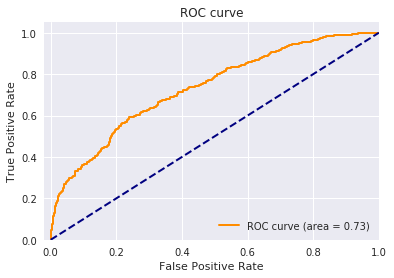

Training time: 14.09 minutes
0:14:05.596983
CPU times: user 1h 50min 36s, sys: 7.01 s, total: 1h 50min 43s
Wall time: 14min 5s


In [18]:
%%time
start_time = dt.datetime.now()
print("Start time: ",start_time)
preds, imp, model = run_single(X_train, X_test, y_train, y_test,2019)
print(dt.datetime.now()-start_time)

In [19]:
y_pred = model.predict(xgb.DMatrix(X), ntree_limit=model.best_iteration+1)
y_pred = (y_pred > 0.5).astype(int)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


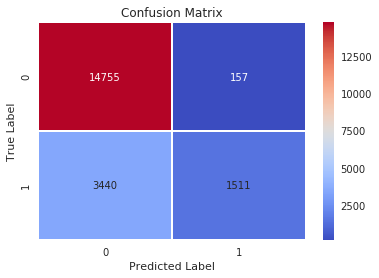

In [20]:
from sklearn import metrics

def plot_confusion_matrix(y, y_hat):
  matrix = metrics.confusion_matrix(y, y_hat)
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix,
              cmap="coolwarm",
              linecolor='white',
              linewidths=1,
              annot=True,
              fmt="d")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()
  
plot_confusion_matrix(y, y_pred)

In [21]:
print(metrics.classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       0.81      0.99      0.89     14912
        1.0       0.91      0.31      0.46      4951

avg / total       0.83      0.82      0.78     19863



In [27]:
# save into file for inspection
df_label['y_pred'] = y_pred
df_label.to_parquet("data/xgboost_raw_data_ypred.parquet")

In [28]:
df_label.head()

,bookingID,count,label,y_pred
index,,,,
3333,0,981,0.0,1
8685,1,607,1.0,0
18906,2,133,1.0,1
2926,4,1023,1.0,0
8283,6,630,0.0,0
